In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ensembles = list(range(0,84))

In [3]:
sio2_dict = {ensemble:{} for ensemble in ensembles}
n_impact_dict = {}
for ensemble in ensembles:
    for layer in range(12):
        with open("./sio2_percent_tables/unbound_30jan2022/ensemble_{:d}_{:d}.csv".format(ensemble, layer), "r")as f:
            sio2_dict[ensemble][layer] = pd.read_csv(f).fillna(0)
    with open("./impact_probabilities_export_unbound_30jan2022/ensemble_{:d}.csv".format(ensemble), "r")as f:
        n_impact_dict[ensemble] = pd.read_csv(f).fillna(0)

In [4]:
df = sio2_dict[1][0].loc[:,[str(p) for p in range(60,71)]].sum(axis=1) / 40

In [5]:
df

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
495    0.233008
496    0.231295
497    0.230958
498    0.231295
499    0.230622
Length: 500, dtype: float64

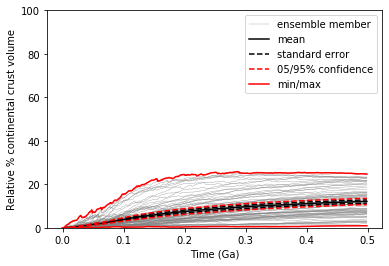

In [9]:
crust_dict = {}
for ensemble in ensembles:
    percent_bins=[]
    for p in range(60,81):
        if str(p) in list(sio2_dict[ensemble][0].columns.values):
            percent_bins.append(str(p))
    df = 100* sio2_dict[ensemble][0].loc[:,percent_bins].sum(axis=1) / 70
    crust_dict[ensemble] = df.values
    if ensemble == 1:
        plt.plot(df.index.values/1000, df.values, lw=0.3, c='grey', label='ensemble member')
    else:
        plt.plot(df.index.values/1000, df.values, lw=0.3, c='grey')
crust_df = pd.DataFrame(crust_dict, index=df.index.values)
crust_mean = crust_df.mean(axis=1)

crust_df['mean'] = crust_df.mean(axis=1)
crust_df['min'] = crust_df.min(axis=1)
crust_df['max'] = crust_df.max(axis=1)
crust_df['stdev'] = crust_df.std(axis=1)
standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
crust_df['e05'] = crust_df['mean'] - standard_error
crust_df['e95'] = crust_df['mean'] + standard_error
crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
crust_df['c05'] = crust_df['mean'] - standard_error * 1.96

plt.plot(df.index.values/1000, crust_df['mean'], c='k', label='mean')
plt.plot(df.index.values/1000, crust_df['e05'], '--', c='k', label='standard error')
plt.plot(df.index.values/1000, crust_df['e95'], '--', c='k')
plt.plot(df.index.values/1000, crust_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(df.index.values/1000, crust_df['c95'], '--', c='r')
plt.plot(df.index.values/1000, crust_df['min'].clip(lower=0), c='r', label='min/max')
plt.plot(df.index.values/1000, crust_df['max'], c='r')
plt.xlabel("Time (Ga)")
plt.ylabel("Relative % continental crust volume")
plt.ylim([0,100])
plt.legend()
plt.savefig('./figs/paper_figs/relative_percent_crust_over_time_unbound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/relative_percent_crust_over_time_unbound.png', dpi=600)
plt.show()
plt.close()

['Unnamed: 0' '45' '50' '51' '59' '58' '49' '55' '53' '52' '54' '48' '63'
 '62' '64' '73' '65' '66' '57' '72' '67' '69' '68' '61' '70' '71' '74'
 '56' '47' '85' '60' '81' '80' '90' '40' '77' '41' '35' '79' '46' '89'
 '37' '78' '95' '42' '82' '44' '34' '75' '84' '38' '24' '76' '86' '43'
 '39' '83' '88' '36' '87' '32' '93' '91' '30' '99' '20' '92' '31']
21
['Unnamed: 0' '37' '45' '50' '51' '49' '55' '40' '53' '52' '54' '48' '39'
 '38' '47' '41' '36' '35' '46' '34' '43']
0
['Unnamed: 0' '45' '50' '37' '51' '36' '55' '49' '40' '53' '52' '54' '39'
 '48' '38' '47' '35' '46' '34' '43']
0
['Unnamed: 0' '45' '50' '37' '51' '40' '36' '55' '53' '52' '54' '38' '39'
 '48' '49' '47' '35' '46' '33' '32']
0
['Unnamed: 0' '37' '45' '50' '36' '38' '40' '39' '51' '52' '55' '48' '53'
 '49' '54' '35' '34' '47' '33' '32']
0
['Unnamed: 0' '37' '45' '50' '36' '38' '40' '39' '51' '52' '48' '53' '49'
 '55' '35' '54' '34' '33']
0
['Unnamed: 0' '37' '45' '50' '36' '40' '51' '52' '39' '48' '49' '53' '38'
 '35' '34

['Unnamed: 0' '45' '50' '59' '53' '55' '54' '51' '52' '62' '67' '73' '39'
 '49' '58' '60' '91' '48' '65' '42' '76' '56' '61' '63' '64' '72' '37'
 '71' '57' '31' '46' '70' '87' '97' '34' '69' '66' '44' '77' '47' '38'
 '68' '79' '36' '81' '74' '30' '43' '41' '80' '82' '33' '40' '75' '78'
 '95' '27' '29' '19' '35' '86' '32' '85' '83' '92' '84' '88' '26' '93'
 '96' '89' '23' '28' '21' '98' '100' '25' '90' '20' '94' '7' '1' '22' '16'
 '11' '18' '8' '17' '15' '24' '5' '13']
21
['Unnamed: 0' '45' '50' '37' '53' '55' '40' '51' '52' '54' '48' '49' '41'
 '46' '36' '47' '38' '39' '32' '35' '44' '34']
0
['Unnamed: 0' '37' '45' '50' '39' '40' '55' '51' '52' '53' '54' '38' '36'
 '48' '49' '35' '34' '47' '33' '46' '32' '44']
0
['Unnamed: 0' '37' '45' '50' '39' '55' '40' '51' '52' '53' '54' '36' '48'
 '49' '35' '38' '47' '33' '34' '32' '46']
0
['Unnamed: 0' '37' '45' '50' '40' '51' '52' '39' '53' '54' '36' '48' '49'
 '38' '47' '55' '35' '34' '33']
0
['Unnamed: 0' '37' '45' '50' '40' '51' '52' '38' '39

['Unnamed: 0' '37' '45' '50' '51' '55' '54' '40' '49' '53' '52' '47' '39'
 '38' '46' '41' '36' '44' '48' '35' '33']
0
['Unnamed: 0' '37' '45' '50' '38' '40' '55' '54' '49' '51' '53' '36' '52'
 '47' '46' '39' '35' '34' '32' '48' '33' '44']
0
['Unnamed: 0' '45' '50' '38' '40' '55' '37' '54' '36' '39' '51' '52' '47'
 '46' '49' '53' '35' '34' '32' '33' '48' '44']
0
['Unnamed: 0' '37' '45' '50' '40' '55' '54' '36' '39' '51' '38' '47' '52'
 '34' '49' '53' '35' '32']
0
['Unnamed: 0' '37' '45' '50' '40' '51' '38' '55' '54' '47' '52' '34' '39'
 '49' '36' '35' '32']
0
['Unnamed: 0' '37' '45' '50' '40' '51' '55' '54' '39' '38' '47' '52' '34'
 '49' '36' '35']
0
['Unnamed: 0' '37' '45' '50' '40' '51' '39' '47' '52' '38' '49' '36']
0
['Unnamed: 0' '37' '45' '50' '51' '40' '39' '47' '36' '49' '35']
0
['Unnamed: 0' '45' '50' '37' '51' '40' '39' '47' '36' '35' '49']
0
['Unnamed: 0' '37' '45' '50' '40' '39' '35' '36']
0
['Unnamed: 0' '37' '45' '50' '35' '39' '36']
0
['Unnamed: 0' '45' '50' '41' '47' '54

 '48' '33' '54' '51' '32' '47' '31' '30']
0
['Unnamed: 0' '37' '45' '50' '36' '49' '40' '35' '38' '39' '34' '52' '53'
 '48' '51' '33' '47' '32' '31']
0
['Unnamed: 0' '45' '50' '37' '36' '49' '39' '38' '40' '35' '52' '48' '51'
 '34' '33' '32' '47']
0
['Unnamed: 0' '45' '50' '36' '37' '49' '38' '39' '48' '35' '47']
0
['Unnamed: 0' '45' '50' '37' '36' '49' '38' '39' '48' '35']
0
['Unnamed: 0' '37' '45' '36' '50' '49' '38' '39' '35']
0
['Unnamed: 0' '37' '45' '36' '50' '49' '38' '35']
0
['Unnamed: 0' '45' '50' '59' '49' '51' '52' '55' '58' '63' '41' '54' '65'
 '53' '62' '67' '69' '73' '48' '70' '86' '42' '66' '71' '56' '91' '64'
 '57' '60' '68' '77' '61' '72' '87' '78' '79' '47' '81' '39' '40' '36'
 '46' '74' '75' '82' '32' '37' '76' '34' '83' '35' '38' '43' '84' '26'
 '80' '92' '95' '99' '89' '31' '98' '24' '100' '20' '93' '44' '25' '22'
 '96' '85' '97' '33' '30' '21' '8' '27' '90' '29' '18' '11' '12' '1' '28'
 '9' '94' '17' '19' '88' '13' '23' '15' '10' '3' '16' '14' '6' '2' '4' '7'
 '5'

['Unnamed: 0' '45' '50' '44' '59' '55' '49' '52' '46' '51' '53' '67' '54'
 '39' '60' '73' '62' '57' '69' '71' '61' '64' '58' '72' '65' '41' '66'
 '48' '56' '63' '74' '47' '70' '68' '37' '43' '87' '91' '95' '80' '42'
 '34' '81' '35' '40' '29' '86' '30' '77' '82' '24' '76' '88' '75' '78'
 '96' '31' '90' '100' '84' '85' '28' '83' '98' '36' '25' '89' '93' '38'
 '97' '99' '94' '79' '32' '92' '22' '23' '26' '18' '27' '33']
21
['Unnamed: 0' '37' '45' '50' '55' '40' '51' '49' '53' '54' '52' '36' '41'
 '38' '39' '47' '48' '43' '46' '35']
0
['Unnamed: 0' '37' '45' '50' '40' '55' '51' '49' '53' '36' '54' '52' '41'
 '39' '47' '48' '34' '46' '38' '35']
0
['Unnamed: 0' '37' '45' '50' '40' '55' '49' '53' '54' '52' '51' '38' '47'
 '48' '36' '35' '39' '34' '46']
0
['Unnamed: 0' '37' '45' '50' '40' '36' '39' '55' '53' '38' '51' '49' '35'
 '48' '54' '52' '34']
0
['Unnamed: 0' '37' '45' '50' '40' '36' '39' '55' '38' '49' '35' '54' '52'
 '48' '34']
0
['Unnamed: 0' '37' '45' '50' '36' '39' '55' '40' '49' '3

['Unnamed: 0' '45' '50' '52' '55' '58' '59' '48' '49' '51' '54' '57' '53'
 '71' '73' '62' '60' '61' '56' '65' '46' '47' '68' '67' '72' '69' '63'
 '64' '70' '66' '37' '42' '43' '78' '31' '28' '41' '44' '79' '85' '81'
 '40' '35' '36' '80' '39' '75' '76' '38' '30' '24' '32' '29' '33' '34'
 '83' '86' '18' '84' '82' '23' '93' '25' '90']
19
['Unnamed: 0' '45' '50' '52' '55' '37' '48' '49' '51' '54' '53' '39' '40'
 '46' '47' '41' '38' '34' '42' '30' '44' '36' '43' '33']
0
['Unnamed: 0' '37' '45' '50' '52' '55' '40' '48' '49' '51' '54' '53' '46'
 '47' '38' '39' '35' '34' '36' '42' '41' '44' '43' '30']
0
['Unnamed: 0' '37' '45' '50' '52' '55' '35' '49' '40' '51' '48' '53' '54'
 '39' '46' '47' '38' '36' '34' '42' '33' '44' '41' '32' '43' '30']
0
['Unnamed: 0' '37' '45' '50' '40' '52' '35' '49' '51' '55' '48' '53' '54'
 '39' '46' '47' '38' '33' '36' '34' '31' '32' '42' '30' '44']
0
['Unnamed: 0' '37' '45' '50' '36' '40' '52' '49' '51' '55' '48' '53' '54'
 '39' '34' '35' '47' '38' '33' '46' '31' '

['Unnamed: 0' '45' '50' '55' '59' '58' '49' '53' '48' '54' '51' '52' '57'
 '64' '65' '62' '67' '73' '56' '63' '68' '61' '66' '71' '70' '88' '72'
 '47' '60' '69' '46' '84' '79' '75' '44' '43' '83' '94' '90' '82' '76'
 '85' '80' '74' '87' '89' '42' '38' '33' '77' '81' '100' '29' '35' '78'
 '23' '8' '86' '41' '22' '37' '36' '98' '34' '91' '96' '99' '40' '97' '92'
 '95']
21
['Unnamed: 0' '37' '45' '50' '55' '40' '49' '53' '36' '54' '51' '52' '41'
 '38' '48' '47' '46' '39' '42' '44']
0
['Unnamed: 0' '37' '45' '50' '40' '55' '49' '53' '54' '51' '52' '38' '39'
 '36' '48' '47' '46' '35' '32' '33' '44' '34']
0
['Unnamed: 0' '37' '45' '50' '55' '40' '49' '53' '54' '51' '52' '39' '36'
 '38' '48' '47' '34' '35' '46' '32' '33']
0
['Unnamed: 0' '37' '45' '50' '40' '49' '53' '39' '52' '51' '55' '54' '36'
 '38' '48' '47' '34' '35' '46' '33']
0
['Unnamed: 0' '37' '45' '50' '40' '49' '53' '39' '52' '38' '51' '48' '54'
 '36' '47' '34' '35' '33']
0
['Unnamed: 0' '37' '45' '50' '40' '49' '39' '38' '51' '53

['Unnamed: 0' '37' '45' '50' '36' '39' '38' '35' '49' '51' '47' '34' '48'
 '46' '33' '40']
0
['Unnamed: 0' '37' '45' '50' '36' '38' '35' '49' '34' '47' '33' '39' '48']
0
['Unnamed: 0' '37' '45' '50' '36' '35' '38' '49' '34' '47' '33' '48']
0
['Unnamed: 0' '45' '50' '55' '59' '43' '51' '54' '52' '62' '73' '91' '53'
 '67' '64' '58' '76' '49' '57' '70' '60' '61' '48' '63' '68' '56' '72'
 '65' '69' '71' '66' '47' '85' '92' '89' '77' '74' '80' '87' '42' '41'
 '78' '84' '82' '98' '81' '83' '88' '34' '40' '46' '75' '79' '97' '35'
 '94' '95' '100' '25' '86' '99' '44' '96' '33' '38' '90' '93' '31' '22'
 '36']
21
['Unnamed: 0' '45' '50' '55' '40' '51' '37' '53' '54' '52' '49' '48' '39'
 '41' '47' '38' '36']
0
['Unnamed: 0' '37' '45' '50' '55' '40' '51' '39' '52' '53' '54' '49' '36'
 '38' '48' '47' '35' '41' '33']
0
['Unnamed: 0' '45' '50' '37' '40' '51' '55' '39' '38' '52' '53' '54' '49'
 '48' '36' '47' '35' '34']
0
['Unnamed: 0' '37' '45' '50' '40' '55' '38' '52' '39' '51' '36' '49' '54'
 '48' 

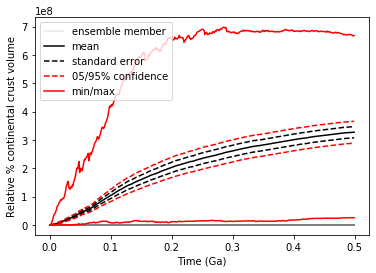

In [10]:
n_layers=12
crust_dict = {}
for ensemble in ensembles:
    for layer in range(n_layers):
        
        percent_bins=[]
        for p in range(60,81):
            if str(p) in list(sio2_dict[ensemble][layer].columns.values):
                percent_bins.append(str(p))
 
        print(sio2_dict[ensemble][layer].columns.values)
        print(len(percent_bins))
                
        # Num grid cells * area [km2] * layer depth [km] * percent area
        percent_to_volume = 14904 * (36 * 36) * 2
        df = percent_to_volume * sio2_dict[ensemble][layer].loc[:,percent_bins].sum(axis=1)

        if layer == 0:
            crust_dict[ensemble] = df.values
        else:
            crust_dict[ensemble] += df.values
           
    df = df / percent_to_volume / n_layers
        
    # surface area of earth [km2] * layer depth [km] / current total crustal volume [km3]
    multiplier_for_relative_percent = ((5.1e8) * 2)/(7.2e9)
    
    df = multiplier_for_relative_percent * df
            
    if ensemble == 0:
        plt.plot(df.index.values/1000, df.values, lw=0.3, c='grey', label='ensemble member')
    else:
        plt.plot(df.index.values/1000, df.values, lw=0.3, c='grey')
            
    crust_df = pd.DataFrame(crust_dict, index=df.index.values)
    
    crust_mean = crust_df.mean(axis=1)

crust_df['mean'] = crust_df.mean(axis=1)
crust_df['min'] = crust_df.min(axis=1)
crust_df['max'] = crust_df.max(axis=1)
crust_df['stdev'] = crust_df.std(axis=1)
standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
crust_df['e05'] = crust_df['mean'] - standard_error
crust_df['e95'] = crust_df['mean'] + standard_error
crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
crust_df['c05'] = crust_df['mean'] - standard_error * 1.96

plt.plot(df.index.values/1000, crust_df['mean'], c='k', label='mean')
plt.plot(df.index.values/1000, crust_df['e05'], '--', c='k', label='standard error')
plt.plot(df.index.values/1000, crust_df['e95'], '--', c='k')
plt.plot(df.index.values/1000, crust_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(df.index.values/1000, crust_df['c95'], '--', c='r')
plt.plot(df.index.values/1000, crust_df['min'].clip(lower=0), c='r', label='min/max')
plt.plot(df.index.values/1000, crust_df['max'], c='r')
plt.xlabel("Time (Ga)")
plt.ylabel("Relative % continental crust volume")
#plt.ylim([0,20])
plt.legend()
plt.savefig('./figs/paper_figs/relative_percent_crust_over_time_bound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/relative_percent_crust_over_time_bound.png', dpi=600)
plt.show()
plt.close()

In [11]:
final_values = {summary_characteristic:[] for summary_characteristic in ['mean', 'min', 'max',
                                                                         'standard_error', 'CI95']}
for i in range(3,len(ensembles)+1):
    crust_dict = {}
    for ensemble in ensembles[:i]:
        percent_bins=[]
        for p in range(60,100):
            if str(p) in list(sio2_dict[ensemble][0].columns.values):
                percent_bins.append(str(p))
        df = 100* sio2_dict[ensemble][0].loc[:,percent_bins].sum(axis=1) / 40
        crust_dict[ensemble] = df.values
    crust_df = pd.DataFrame(crust_dict, index=df.index.values)
    crust_mean = crust_df.mean(axis=1)
    crust_df['mean'] = crust_df.mean(axis=1)
    crust_df['min'] = crust_df.min(axis=1)
    crust_df['max'] = crust_df.max(axis=1)
    crust_df['stdev'] = crust_df.std(axis=1)
    standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
    crust_df['e05'] = crust_df['mean'] - standard_error
    crust_df['e95'] = crust_df['mean'] + standard_error
    crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
    crust_df['c05'] = crust_df['mean'] - standard_error * 1.96
    final_values['mean'].append(crust_df['mean'][499])
    final_values['min'].append(crust_df['min'][499])
    final_values['max'].append(crust_df['max'][499])
    final_values['standard_error'].append(standard_error[499])
    final_values['CI95'].append(standard_error[499] * 1.96)

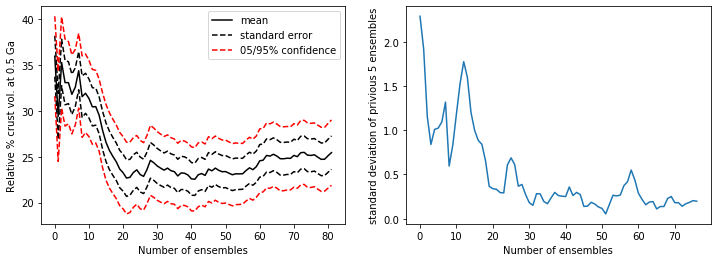

In [12]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)    
ax.plot(final_values['mean'], c='k', label='mean')
ax.plot(np.array(final_values['mean'])+np.array(final_values['standard_error']), 
         '--', c='k', label='standard error')
ax.plot(np.array(final_values['mean'])-np.array(final_values['standard_error']),'--', c='k', )
ax.plot(np.array(final_values['mean'])+np.array(final_values['CI95']), 
         '--', c='r', label='05/95% confidence')
ax.plot(np.array(final_values['mean'])-np.array(final_values['CI95']),'--', c='r', )
ax.set_xlabel("Number of ensembles")
ax.set_ylabel("Relative % crust vol. at 0.5 Ga")
plt.legend()

std_last_5_ens = []
for i in range(5,len(final_values['mean'])):
    std_last_5_ens.append(np.std(final_values['mean'][i-5:i]))
ax = fig.add_subplot(1, 2, 2)
ax.plot(std_last_5_ens)
ax.set_xlabel("Number of ensembles")
ax.set_ylabel("standard deviation of privious 5 ensembles")
plt.savefig('./figs/paper_figs/ensemble_convergence_unbound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/ensemble_convergence_unbound.png', dpi=600)
plt.show()
plt.close()

In [13]:
total_impact_dict = {}
total_impact_dict['low'] = n_impact_dict[ensemble].low
total_impact_dict['high'] = n_impact_dict[ensemble].high
for ensemble in ensembles:
    total_impact_dict[ensemble] = n_impact_dict[ensemble].total

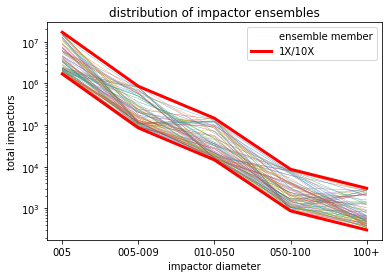

In [14]:
for ensemble in ensembles:
    if ensemble == 1:
        plt.plot(total_impact_dict[ensemble], lw=0.03, label="ensemble member")
    else:
        plt.plot(total_impact_dict[ensemble], lw=0.3)
plt.plot(n_impact_dict[1]['Unnamed: 0'], total_impact_dict['low'], c='r', lw=3, label='1X/10X')
plt.plot(n_impact_dict[1]['Unnamed: 0'], total_impact_dict['high'], c='r', lw=3)
plt.ylabel('total impactors')
plt.yscale('log')
plt.xlabel("impactor diameter")
plt.title("distribution of impactor ensembles")
plt.legend()
plt.savefig('./figs/paper_figs/total_impacts_unbound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/total_impacts_unbound.png', dpi=600)
plt.show()
plt.close()

In [15]:
max_sio2_list={layer:{} for layer in range(12)}
for layer in range(11):
    for ensemble in ensembles:
        max_sio2_list[layer][ensemble]=[]
        for irow in sio2_dict[ensemble][layer].index.values:
            max_sio2_percent=0
            for icol in sio2_dict[ensemble][layer].columns.values[1:]:
                if sio2_dict[ensemble][layer].loc[irow,icol] > 0:
                    if int(icol) > max_sio2_percent:
                        max_sio2_percent = int(icol)
            max_sio2_list[layer][ensemble].append(max_sio2_percent)

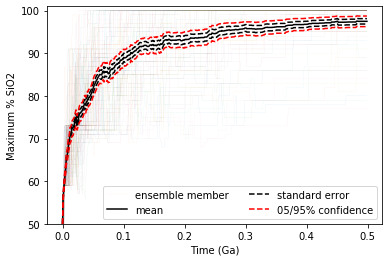

In [16]:
count_within_bounds = 0

max_sio2_df          = pd.DataFrame(max_sio2_list[0])
max_sio2_df['mean']  = max_sio2_df.mean(axis=1)
max_sio2_df['min']   = max_sio2_df.min(axis=1)
max_sio2_df['max']   = max_sio2_df.max(axis=1)
max_sio2_df['stdev'] = max_sio2_df.std(axis=1)
standard_error       = max_sio2_df['stdev']/np.sqrt(len(ensembles))
max_sio2_df['e05']   = max_sio2_df['mean'] - standard_error
max_sio2_df['e95']   = max_sio2_df['mean'] + standard_error
max_sio2_df['c95']   = max_sio2_df['mean'] + standard_error * 1.96
max_sio2_df['c05']   = max_sio2_df['mean'] - standard_error * 1.96
for ensemble in ensembles:
    if ensemble == 1:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_list[0][ensemble], 
                 lw=0.03, label="ensemble member")        
    else:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_list[0][ensemble], lw=0.03)
        
    if np.max(max_sio2_list[0][ensemble]) <= 80 and np.min(max_sio2_list[0][ensemble]) >= 40:
        count_within_bounds+=1

plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], c='k', label='mean')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['e05'], '--', c='k', label='standard error')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['e95'], '--', c='k')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['c95'], '--', c='r')
# plt.plot(max_sio2_df.index.values/1000, max_sio2_df['min'].clip(lower=0), c='r', label='min/max')
# plt.plot(max_sio2_df.index.values/1000, max_sio2_df['max'], c='r')
plt.xlabel("Time (Ga)")
plt.ylabel("Maximum % SiO2")
plt.ylim([50,101])
plt.legend(ncol=2)
plt.savefig('./figs/paper_figs/max_sio2_unbound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/max_sio2_unbound.png', dpi=600)
plt.show()
plt.close()

In [17]:
count_within_bounds

0

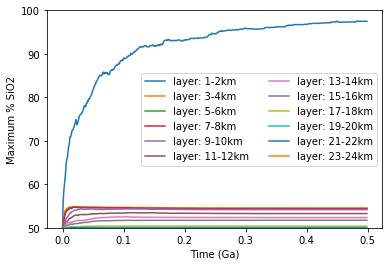

In [19]:
llyr = {0:"1-2km",1:"3-4km",2:"5-6km",3:"7-8km",4:"9-10km",5:"11-12km",
        6:"13-14km",7:"15-16km",8:"17-18km",9:"19-20km",10:"21-22km",11:"23-24km"}
for layer in range(12):
    max_sio2_df          = pd.DataFrame(max_sio2_list[layer])
    max_sio2_df['mean']  = max_sio2_df.mean(axis=1)
    plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], label=f'layer: {llyr[layer]}')
plt.xlabel("Time (Ga)")
plt.ylabel("Maximum % SiO2")
plt.ylim([50,100])
plt.legend(ncol=2)
plt.savefig('./figs/paper_figs/max_sio2_unbound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/max_sio2_unbound.png', dpi=600)
plt.show()
plt.close()